<a href="https://colab.research.google.com/github/M-Amrollahi/Personal-Notes/blob/master/ML-notes/generate_circle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import random
import cv2
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
#from transformers import AutoModel, AutoTokenizer

In [119]:
def f_createRandomImage():
    x,y = 35,35
    max_r = 10
    rangex, rangey = (max_r,x-max_r), (max_r,y-max_r)
    colors = [((255, 255, 0),0),((255, 0, 255),1),((0, 255, 255),2),((50, 50, 0),3),((255, 0, 0),4)]
    lst_res = []
    for color in colors:
        for i in range(800):
            
            frame = np.full((x,y,3),0,dtype="uint8")

            locx = random.randint(*rangex)
            locy = random.randint(*rangey)
            r = random.randint(8,max_r)
            
            
            cv2.circle(frame,(locx,locy),r,color[0],-1)

            frame = frame / 255.0
            #cv2.rectangle(frame,(locx-r,locy-r),(locx+r,locy+r),(0,255,0),1)
            lst_res.append([frame, locx-r, locy-r, locx + r, locy + r, color[1]])
            #cv2.waitKey(0)

    return lst_res

In [148]:
class cls_model(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1,1024),
            nn.Tanh(),
            nn.LayerNorm(1024),
            nn.Linear(1024,31*31),
            nn.ReLU(),
            
        )

        self.tconv1 = nn.ConvTranspose2d(1,1,(3,3))
        self.tconv2 = nn.ConvTranspose2d(1,3,(3,3))

    def forward(self,x):

        y = self.model.forward(x)

        y = y.reshape((x.shape[0], 1, 31, 31))

        y = self.tconv1.forward(y)
        y = self.tconv2.forward(y)

        return y

In [108]:
class cls_data(Dataset):
    def __init__(self,df) -> None:
        super().__init__()

        self.dataset = df

        print("Head of dataset: ", self.dataset.head(2))
        

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        
        return torch.tensor(self.dataset.loc[index, "c"]).unsqueeze(dim=0), torch.tensor(self.dataset.loc[index, "image"]).permute((2,0,1))

In [149]:
lst_data = f_createRandomImage()
df1 = pd.DataFrame({"image":[i[0] for i in lst_data], "c":[i[5] for i in lst_data]})

df_train , df_test = train_test_split(df1,test_size=.01,stratify=df1.c)

ds_train = cls_data(df_train.reset_index().drop(columns=["index"]))

ds_test = cls_data(df_test.reset_index().drop(columns=["index"]))

trainLoader = DataLoader(ds_train,batch_size=8)
testLoader = DataLoader(ds_test,batch_size=8)

Head of dataset:                                                 image  c
0  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...  2
1  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...  2
Head of dataset:                                                 image  c
0  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...  0
1  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...  4


In [90]:
ds_train[1][1].shape

torch.Size([3, 35, 35])

In [150]:
def f_train(net, criterion, trainLoader, valLoader, optim, device):

    net = net.to(device)
    for ep in range(10):
        for x_batch, y_batch in trainLoader:
            
            x_batch, y_batch = x_batch.to(device).float(), y_batch.to(device).float()

            predict = net(x_batch)

            loss = criterion(predict, y_batch)
            optim.zero_grad()

            loss.backward()
            optim.step()           
        
        print("loss", loss)

In [151]:
net = cls_model()

criterion = nn.MSELoss()
optim = torch.optim.Adam(net.parameters(), lr=1e-3)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [152]:
f_train(net, criterion, trainLoader,testLoader,optim, device)

loss tensor(0.0782, grad_fn=<MseLossBackward0>)
loss tensor(0.0756, grad_fn=<MseLossBackward0>)
loss tensor(0.0751, grad_fn=<MseLossBackward0>)
loss tensor(0.0730, grad_fn=<MseLossBackward0>)
loss tensor(0.0715, grad_fn=<MseLossBackward0>)
loss tensor(0.0685, grad_fn=<MseLossBackward0>)
loss tensor(0.0665, grad_fn=<MseLossBackward0>)
loss tensor(0.0663, grad_fn=<MseLossBackward0>)
loss tensor(0.0654, grad_fn=<MseLossBackward0>)
loss tensor(0.0650, grad_fn=<MseLossBackward0>)


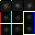

In [153]:
a= net(torch.tensor([[4.]]).to(device))
Image.fromarray( (a[0]*255).type(torch.uint8).cpu().numpy().reshape(35,35,3))

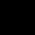

In [127]:
Image.fromarray(lst_data[2500][0].astype(np.uint8).reshape(35,35,3)*255)

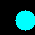

In [142]:
Image.fromarray(lst_data[2300][0].astype(np.uint8)*255)